<a href="https://colab.research.google.com/github/Daniel1989/fastai_course/blob/main/fastai_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import os
from google.colab import userdata
# Replace with your Pexels API key
API_KEY = userdata.get('PEXELS_API_KEY')
BASE_URL = "https://api.pexels.com/v1/search"

def search_and_download_images(query, num_images=5):
    save_dir = "./downloaded_images/"+query
    # Create save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Set up headers with API key
    headers = {
        "Authorization": API_KEY
    }

    # Set up parameters for the API request
    params = {
        "query": query,
        "per_page": num_images
    }

    try:
        # Make the API request
        response = requests.get(BASE_URL, headers=headers, params=params)
        response.raise_for_status()  # Raise an exception for bad status codes

        # Parse the JSON response
        data = response.json()
        photos = data.get("photos", [])

        if not photos:
            print("No images found for the query.")
            return

        # Download each image
        for i, photo in enumerate(photos, 1):
            image_url = photo["src"]["original"]
            image_extension = image_url.split(".")[-1]
            filename = f"{save_dir}/{query.replace(' ', '_')}_{i}.{image_extension}"

            # Download the image
            image_response = requests.get(image_url)
            image_response.raise_for_status()

            # Save the image locally
            with open(filename, "wb") as f:
                f.write(image_response.content)
            print(f"Downloaded: {filename}")

    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")


In [2]:
# 这个包含了fastai框架
!pip install -Uqq fastbook

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
# 初始化
import fastbook
fastbook.setup_book()

Mounted at /content/gdrive


In [4]:
number_of_images = 100
search_and_download_images("cat", number_of_images)
search_and_download_images("dog", number_of_images)
search_and_download_images("bird", number_of_images)

Downloaded: ./downloaded_images/cat/cat_1.jpeg
Downloaded: ./downloaded_images/cat/cat_2.jpeg
Downloaded: ./downloaded_images/cat/cat_3.jpeg
Downloaded: ./downloaded_images/cat/cat_4.jpeg
Downloaded: ./downloaded_images/cat/cat_5.jpeg
Downloaded: ./downloaded_images/cat/cat_6.jpeg
Downloaded: ./downloaded_images/cat/cat_7.jpeg
Downloaded: ./downloaded_images/cat/cat_8.jpg
Downloaded: ./downloaded_images/cat/cat_9.jpeg
Downloaded: ./downloaded_images/cat/cat_10.jpeg
Downloaded: ./downloaded_images/cat/cat_11.jpeg
Downloaded: ./downloaded_images/cat/cat_12.jpeg
Downloaded: ./downloaded_images/cat/cat_13.jpeg
Downloaded: ./downloaded_images/cat/cat_14.jpeg
Downloaded: ./downloaded_images/cat/cat_15.jpeg
Downloaded: ./downloaded_images/cat/cat_16.jpeg
Downloaded: ./downloaded_images/cat/cat_17.jpeg
Downloaded: ./downloaded_images/cat/cat_18.jpeg
Downloaded: ./downloaded_images/cat/cat_19.jpeg
Downloaded: ./downloaded_images/cat/cat_20.jpeg
Downloaded: ./downloaded_images/cat/cat_21.jpeg
Do

In [5]:
from fastbook import *
from fastai.vision.widgets import *
# 5个组成部分，block，一个
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # 前者自变量是我们用来进行预测的因素，而后者因变量是我们的目标。
    get_items=get_image_files, # get_image_files function takes a path, and returns a list of all of the images in that path (recursively, by default)
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # seed通过提供同样的启动点，来确保创建的数值一致
    get_y=parent_label, # 一个function 获取y的label
    item_tfms=Resize(128)) # 将所有图片弄成一个size，这样产生的tensorsize才一致

In [6]:
path = Path('downloaded_images')
dls = bears.dataloaders(path)


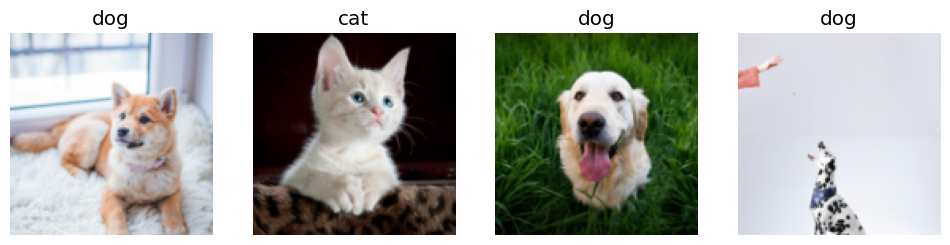

In [7]:
dls.valid.show_batch(max_n=4, nrows=1)


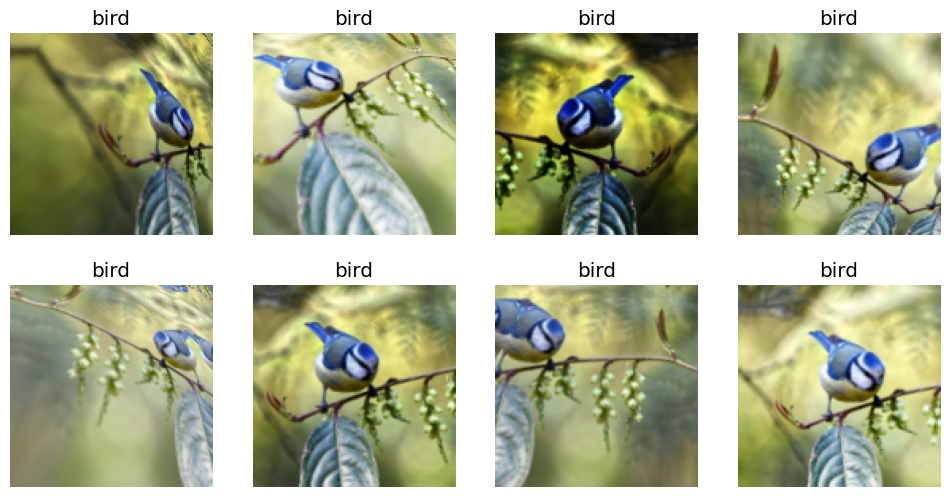

In [8]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
# TODO 如果数据太少，这里会报错，找不到batch
# 当使用DataBlock时，默认的batchSize是64
# 可以通过如下方式修改

# dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
#                    get_items=get_image_files,
#                    get_y=parent_label,
#                    splitter=RandomSplitter())
# dls = dblock.dataloaders(path, bs=32) 这里使用bs参数进行设置

dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [9]:
# within an epoch in fastai,
# all images are first processed with RandomResizedCrop individually,
# then batched,
# and afterward, the images in each batch are processed with aug_transforms before the resulting batch is passed to the model for training.
# This reflects the typical workflow in fastai’s data pipeline.


bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

In [10]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 189MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.961473,0.468431,0.187500,01:02


epoch,train_loss,valid_loss,error_rate,time
0,0.687585,0.241515,0.104167,01:01
1,0.555356,0.181761,0.104167,00:58
2,0.396467,0.180852,0.104167,01:02
3,0.322078,0.197829,0.104167,01:04
